In [1]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as tf_hub
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping
nltk.download('stopwords')
nltk.download('punkt')
!pip install pysastrawi
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.layers import BatchNormalization
# nltk.download('stopwords')
# nltk.download('punkt')
# !pip install pysastrawi

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import requests

url_train = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt"
url_train_label = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt"

url_val_text = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_text.txt"
url_val_labels = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_labels.txt"




train_data = requests.get(url_train)
trainlabel_data = requests.get(url_train_label)

val_data = requests.get(url_val_text)
vallabel_data = requests.get(url_val_labels)



train_data1 = train_data.text.split("\n")

train_data1_label = trainlabel_data.text.split("\n")

val_data1 = val_data.text.split("\n")
val_data1_label = vallabel_data.text.split("\n")


# for line in data:
# print(train_data1[:5])



In [3]:
# Define Stopwords

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# Define stopwords for English
stopwords_en = set(stopwords.words('english'))

# Initialize Porter Stemmer
stemmer_en = PorterStemmer()

def text_preprocessing(text):
    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub("@[A-Za-z0-9_]+", " ", text)

    # Hashtags removal
    text = re.sub("#[A-Za-z0-9_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\\n", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
    text = re.sub("[^A-Za-z\s']", " ", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopwords removal
    tokens = [word for word in tokens if word not in stopwords_en]

    # Stemming using Porter Stemmer
    tokens = [stemmer_en.stem(word) for word in tokens]

    # Combining Tokens
    text = ' '.join(tokens)

    return text


In [4]:
train_data_processning = [text_preprocessing(text) for text in train_data1]
# for lin in train_data_processning:
#   print(lin)
# print('\n')
# for lin in train_data1:
#   print(lin)

val_data_processning = [text_preprocessing(text) for text in val_data1]


In [5]:


# Extracting text from training and test data
# X_train_texts = [sample[0] for sample in X_train]
# X_test_texts = [sample[0] for sample in X_test]

# Initialise the CountVectorizer and vectorise it.
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(train_data_processning)
X_test_vec = Vectorize.transform(val_data_processning)

# Finding the Number of Vocabs and Max Token Length in One Document
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in train_data_processning])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

# Text Vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(train_data_processning)






Total Vocab :  27398
Maximum Sentence Length :  40 tokens


In [6]:


# ## Document example
# print('Document example')
# print(df.text_processed[0])
# print('')

# ## Result of Text Vectorization
# print('Result of Text Vectorization')
# print(text_vectorization([df.text_processed[0]]))
# print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)



## Document example
print('Document example')
print(train_data_processning[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
# Vectorise the first training data text
text_vectorized = text_vectorization([train_data_processning[0]])
print(text_vectorized)
print('Vector size : ', text_vectorized.shape)


Document example
qt origin draft th book remu lupin surviv battl hogwart

Result of Text Vectorization
tf.Tensor(
[[ 8938   921  1219     6   217  5955  6032  2010  1333 12154     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]], shape=(1, 40), dtype=int64)
Vector size :  (1, 40)


In [7]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'u',
 's',
 'tomorrow',
 'may',
 'th',
 'go',
 'c',
 'day',
 'nt',
 'st',
 'night',
 'see',
 'get',
 'friday',
 'time',
 'like',
 'sunday',
 'm']

In [9]:
train_data_processed = [sentence.split() for sentence in train_data_processning]
print(train_data_processed[:2])


[['qt', 'origin', 'draft', 'th', 'book', 'remu', 'lupin', 'surviv', 'battl', 'hogwart'], ['ben', 'smith', 'smith', 'concuss', 'remain', 'lineup', 'thursday', 'curti']]


In [10]:
import gensim
from gensim.models import Word2Vec
# model = Word2Vec(train_data_processed, vector_size=100, window=5, min_count=3)

word2vec_model = Word2Vec(sentences=train_data_processed, vector_size=128, window=5, min_count=1, workers=4)
word2vec_model.train(train_data_processed, total_examples=len(train_data_processed), epochs=50)

(24044789, 26559000)

In [11]:


tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data_processning)

# Convert text to sequence
X_train_seq = tokenizer.texts_to_sequences(train_data_processning)
X_val_seq = tokenizer.texts_to_sequences(val_data_processning)


# cleaning the invalide data
invalid_indices_train = [i for i, seq in enumerate(X_train_seq) if len(seq) == 0]
invalid_indices_val = [i for i, seq in enumerate(X_val_seq) if len(seq) == 0]

X_train_seq_clean = [seq for i, seq in enumerate(X_train_seq) if i not in invalid_indices_train]
y_train_ohe_clean = np.delete(train_data1_label, invalid_indices_train, axis=0)


X_val_seq_clean = [seq for i, seq in enumerate(X_val_seq) if i not in invalid_indices_val]
y_val_ohe_clean = np.delete(val_data1_label, invalid_indices_val, axis=0)

# update index
max_seq_length = max(len(seq) for seq in X_train_seq_clean + X_val_seq_clean)
X_train_padded_clean = pad_sequences(X_train_seq_clean, maxlen=max_seq_length)
X_val_padded_clean = pad_sequences(X_val_seq_clean, maxlen=max_seq_length)

# update
y_train_ohe_clean = to_categorical(y_train_ohe_clean)
y_val_ohe_clean = to_categorical(y_val_ohe_clean)

print("train data after cleaning:", len(X_train_seq_clean))
print("develop(val) data after cleaning:", len(X_val_seq_clean))


train data after cleaning: 45614
develop(val) data after cleaning: 2000


In [12]:


# Get the pre-trained word embeddings
word_embeddings = word2vec_model.wv

# Get the embedding matrix
embedding_matrix = word_embeddings.vectors

# Get the vocabulary size
vocab_size = len(word_embeddings.key_to_index)

# Update the embedding layer in your neural network model
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=128,
                            weights=[embedding_matrix],
                            input_length=max_seq_length,
                            trainable=False)


# Embedding


# embedding = Embedding(input_dim=total_vocab,
#                       output_dim=128,
#                       embeddings_initializer="uniform",
#                       input_length=max_sen_len)
# Example Result


# print('Document example')
# print(train_data_processning[0])
# print('')

# ## Result of Text Vectorization
# print('Result of Text Vectorization')
# print(text_vectorization([train_data_processning[0]]))
# print('Vector size : ', text_vectorization([train_data_processning[0]]).shape)
# print('')

# ## Result of Embedding
# print('Result of Embedding')
# print(embedding(text_vectorization([train_data_processning[0]])))
# print('Vector size : ', embedding(text_vectorization([train_data_processning[0]])).shape)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 128)           3575552   
                                                                 
 bidirectional_4 (Bidirecti  (None, 32, 16)            8768      
 onal)                                                           
                                                                 
 batch_normalization_4 (Bat  (None, 32, 16)            64        
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 32, 16)            0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 32)                4224      
 onal)                                                           
                                                      

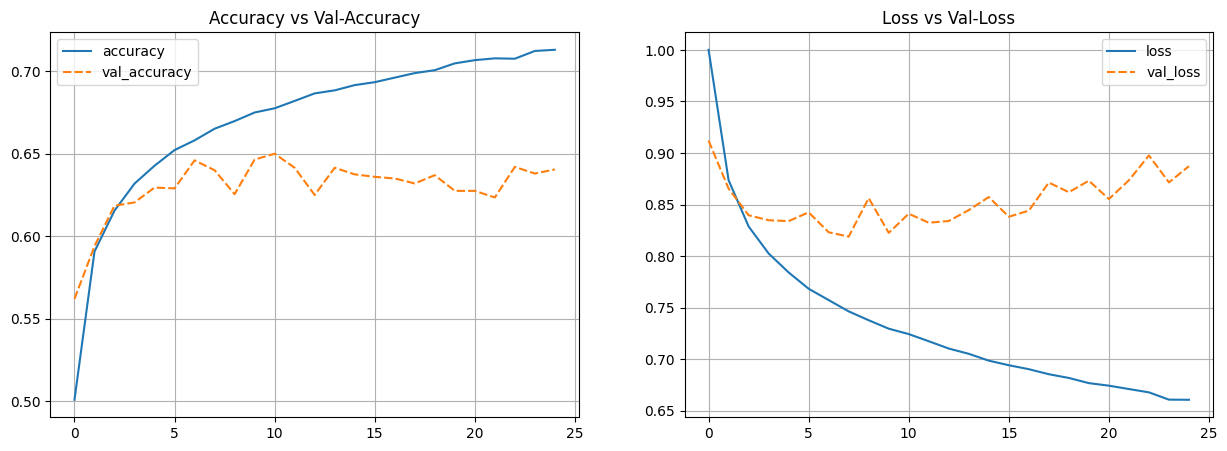

In [15]:


learn_rate = tf.keras.optimizers.Adam(learning_rate =0.001)

model_lstm_1 = Sequential()
model_lstm_1.add(embedding_layer)
# model_lstm_1.add(Embedding(input_dim=10000, output_dim=128, input_length=max_seq_length))
model_lstm_1.add(Bidirectional(LSTM(8, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))))
model_lstm_1.add(BatchNormalization())
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))))
model_lstm_1.add(BatchNormalization())
model_lstm_1.add(Dropout(0.1))
# model_lstm_1.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_lstm_1.add(Dense(3, activation='softmax'))
model_lstm_1.compile(loss='categorical_crossentropy', optimizer=learn_rate, metrics=['accuracy'])
model_lstm_1.summary()
# Fit the model
# batch_size =32
batch_size =32
model_lstm_1_hist = model_lstm_1.fit(X_train_padded_clean,
                                     y_train_ohe_clean,
                                     epochs=25,
                                     batch_size=batch_size,
                                     validation_data=(X_val_padded_clean, y_val_ohe_clean))


# Plot training results
model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')


plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()


In [16]:
best_model_index = model_lstm_1_hist_df['val_accuracy'].idxmax()
best_model = model_lstm_1_hist_df.iloc[best_model_index]
print("Best Model Epoch:", best_model_index + 1)
print("Validation Accuracy:", best_model['val_accuracy'])
print("Validation Loss:", best_model['val_loss'])

# the best model information
print("\nBest Model Summary:")
best_model_summary = model_lstm_1.to_json()
print(best_model_summary)
# saving

# best_model.save("best_model_lstm_1.h5")

Best Model Epoch: 11
Validation Accuracy: 0.6499999761581421
Validation Loss: 0.8410888314247131

Best Model Summary:
{"class_name": "Sequential", "config": {"name": "sequential_2", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 32], "dtype": "float32", "sparse": false, "ragged": false, "name": "embedding_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Embedding", "config": {"name": "embedding", "trainable": false, "dtype": "float32", "batch_input_shape": [null, 32], "input_dim": 27934, "output_dim": 128, "embeddings_initializer": {"module": "keras.initializers", "class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}, "registered_name": null}, "embeddings_regularizer": null, "activity_regularizer": null, "embeddings_constraint": null, "mask_zero": false, "input_length": 32}, "registered_name": null, "build_config": {"input_shape": [null, 32]}}, {"module": "keras.laye